# NYC Agencies - Social Media Engagement, 2011-2012

This dataset includes social media statistics - including likes, follows, visits, and app downloads - from various NYC agencies and organizations. The analysis utilizes Pandas and SQL to determine which platforms (i.e. social media, app downloads, video, etc.) have the most and least engagement.

When downloaded several months ago, the dataset was freely available at: _[NYC Social Media Usage](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=10&cad=rja&uact=8&ved=2ahUKEwj0gZTVn-ThAhXMneAKHSi-DcgQFjAJegQIARAB&url=https%3A%2F%2Fdata.ny.gov%2FRecreation%2FNYC-Social-Media-Usage%2F5b3a-rs48%2Fdata&usg=AOvVaw3M8x-Fibiy1f5omS-tGzF6)_. However, the dataset now appears to have been removed.

In [41]:
import pandas as pd
from matplotlib import pyplot as plt
import sqlite3
import seaborn as sns
%matplotlib inline

First, we need to import the data into a dataframe.  Additionally, a couple of the column names need to be renamed in order to make them easier to reference in our queries.

In [42]:
df = pd.read_csv('/Users/alexustian/stacey_learning/NYC_Social_Media_Usage.csv')

In [43]:
df.rename(columns={'Likes/Followers/Visits/Downloads': 'Interactions', 'Date Sampled': 'Date_Sampled'}, inplace=True)

Now let's examine the first few rows of the data to ensure that the columns were correctly renamed. We can also review the data types to see if any need to be converted.

In [44]:
print(df.head())
df.dtypes

  Agency    Platform                           Url            Date_Sampled  \
0    OEM         SMS                           NaN  02/17/2012 12:00:00 AM   
1    OEM         SMS                           NaN  11/09/2012 12:00:00 AM   
2    EDC      Flickr  http://www.flickr.com/nycedc  05/09/2012 12:00:00 AM   
3  NYCHA  Newsletter                           NaN  05/09/2012 12:00:00 AM   
4    DHS     Twitter        www.twitter.com/nycdhs  06/13/2012 12:00:00 AM   

   Interactions  
0         61652  
1         44547  
2           NaN  
3           NaN  
4           389  


Agency           object
Platform         object
Url              object
Date_Sampled     object
Interactions    float64
dtype: object

If we want to do anything with the Date_Sampled column, we'll need to have it in datetime format, so we can make that change.  Also, because this analysis is focused on user interactions, the rows with empty values in that column will not be used, and can be dropped.

In [45]:
df['Date_Sampled'] =  pd.to_datetime(df['Date_Sampled'], infer_datetime_format=True)

In [46]:
df = df.dropna(subset=['Interactions'])

Since we will be using SQL for this analysis, we also need to convert the dataframe to a SQL table.

In [47]:
conn = sqlite3.connect("Any_Database_Name.db")
df.to_sql('usage', conn, if_exists='replace')

Now we can check to make sure that the dataframe was successfully converted.

In [48]:
pd.read_sql('SELECT * FROM usage LIMIT 10', conn)

,index,Agency,Platform,Url,Date_Sampled,Interactions
0,0,OEM,SMS,None,2012-02-17 00:00:00,61652
1,1,OEM,SMS,None,2012-11-09 00:00:00,44547
2,4,DHS,Twitter,www.twitter.com/nycdhs,2012-06-13 00:00:00,389
3,5,DHS,Twitter,www.twitter.com/nycdhs,2012-08-02 00:00:00,431
4,6,DOH,Android,Condom Finder,2011-08-08 00:00:00,5026
5,8,MOME,Android,MiNY Venor app,2011-08-08 00:00:00,313
6,11,ENDHT,Facebook,http://www.facebook.com/pages/NYC-Lets-End-Hum...,2011-08-08 00:00:00,3
7,12,VAC,Facebook,https://www.facebook.com/pages/NYC-Voter-Assis...,2011-08-08 00:00:00,36
8,13,PlaNYC,Facebook,http://www.facebook.com/pages/New-York-NY/PlaN...,2011-08-08 00:00:00,47
9,14,DFTA,Facebook,http://www.facebook.com/pages/NYC-Department-f...,2011-08-08 00:00:00,90


Let's take a closer look at the distinct values in the 'Platform' column to make sure that there are no duplicates.

In [49]:
pd.read_sql('SELECT DISTINCT platform FROM usage', conn)

,Platform
0,SMS
1,Twitter
2,Android
3,Facebook
4,Flickr
5,Foursquare
6,iPhone App
7,iPhone app
8,Linked-In
9,Newsletter


We can see that there are duplicates due to inconsistant naming conventions.  Let's fix those so that the values are uniform, and can be grouped appropriately.

In [50]:
df['Platform'] = df['Platform'].apply(lambda x :x.replace('Foursquare (Badge Unlock)', 'Foursquare'))
df['Platform'] = df['Platform'].apply(lambda x :x.replace('Youtube', 'YouTube'))
df['Platform'] = df['Platform'].apply(lambda x :x.replace('iPhone app', 'iPhone'))
df['Platform'] = df['Platform'].apply(lambda x :x.replace('iPhone App', 'iPhone'))

We can now reload the data and re-check the 'Platform' column to make sure our changes were successfully made.

In [51]:
df.to_sql('usage', conn, if_exists='replace')
pd.read_sql('SELECT DISTINCT platform FROM usage', conn)

,Platform
0,SMS
1,Twitter
2,Android
3,Facebook
4,Flickr
5,Foursquare
6,iPhone
7,Linked-In
8,Newsletter
9,Tumblr


Now that our data is cleaned up, we can see which platforms have the most user engagement.

In [52]:
pd.read_sql('SELECT Platform, SUM(Interactions) \
            FROM usage \
            WHERE Platform != "TOTAL" \
            GROUP BY platform \
            ORDER BY 2 DESC \
            LIMIT 10', conn)

,Platform,SUM(Interactions)
0,Newsletter,18067849
1,Twitter,8095134
2,Facebook,6870824
3,SMS,999040
4,iPhone,964634
5,Foursquare,602264
6,Tumblr,573950
7,Linked-In,461482
8,Flickr,157881
9,Instagram,134617


This looks good, but it might be more interesting to see how social media engagement in general compares to newsletter 
subscriptions, as opposed to seeing each social media plaform broken out individually. We can do this by classifying 
each platform using a SQL CASE statement.

In [53]:
pd.read_sql('SELECT \
            CASE \
              WHEN Platform = "Twitter" THEN "Social Media"\
              WHEN Platform = "Facebook" THEN "Social Media"\
              WHEN Platform = "Flickr" THEN "Social Media"\
              WHEN Platform = "Tumblr" THEN "Social Media"\
              WHEN Platform = "Foursquare" THEN "Social Media"\
              WHEN Platform = "Instagram" THEN "Social Media"\
              WHEN Platform = "Pinterest" THEN "Social Media"\
              WHEN Platform = "Linked-In" THEN "Social Media"\
              WHEN Platform = "Google+" THEN "Social Media"\
              WHEN Platform = "Newsletter" THEN "Newsletter"\
              WHEN Platform = "Android" THEN "Phone App"\
              WHEN Platform = "iPhone" THEN "Phone App"\
              WHEN Platform = "YouTube" THEN "Video"\
              ELSE "Other"\
            END AS Platform_Type \
            FROM usage \
            WHERE Platform != "TOTAL" \
            LIMIT 10', conn)

,Platform_Type
0,Other
1,Other
2,Social Media
3,Social Media
4,Phone App
5,Phone App
6,Social Media
7,Social Media
8,Social Media
9,Social Media


We can then group by platform type and sum the number of user interactions per platform. This will be saved to a new dataframe so that we can plot the findings.

In [54]:
df2 = pd.read_sql('SELECT Platform_Type, SUM(Interactions) as Interactions \
             FROM \
              (SELECT \
               CASE \
                WHEN Platform = "Twitter" THEN "Social Media"\
                WHEN Platform = "Facebook" THEN "Social Media"\
                WHEN Platform = "Flickr" THEN "Social Media"\
                WHEN Platform = "Tumblr" THEN "Social Media"\
                WHEN Platform = "Foursquare" THEN "Social Media"\
                WHEN Platform = "Instagram" THEN "Social Media"\
                WHEN Platform = "Pinterest" THEN "Social Media"\
                WHEN Platform = "Linked-In" THEN "Social Media"\
                WHEN Platform = "Google+" THEN "Social Media"\
                WHEN Platform = "Newsletter" THEN "Newsletter"\
                WHEN Platform = "Android" THEN "Phone App"\
                WHEN Platform = "iPhone" THEN "Phone App"\
                WHEN Platform = "YouTube" THEN "Video"\
                ELSE "Other"\
               END AS Platform_Type, Interactions \
              FROM usage \
              WHERE Platform != "TOTAL") \
            GROUP BY Platform_Type \
            ORDER BY Interactions DESC', conn)

First, let's take a quick look at how the various platform types measure up. Then we will plot a bar graph with the results.

In [55]:
print(df2.head())

  Platform_Type  Interactions
0    Newsletter      18067849
1  Social Media      16896751
2         Other       1093835
3     Phone App        990962
4         Video        109545


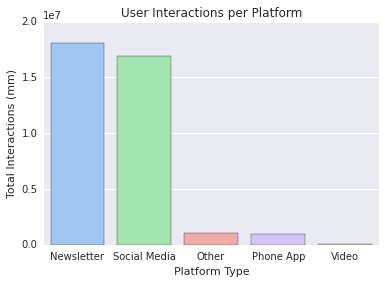

In [58]:
sns.set_palette('pastel')
sns.barplot(data=df2, x='Platform_Type', y='Interactions', estimator=sum)
ax = plt.subplot()
plt.xlabel('Platform Type')
plt.ylabel('Total Interactions (mm)')
plt.title('User Interactions per Platform');

From this analysis, it is clear that in 2011 and 2012, people were not engaging with NYC government agencies via video. Instead, they clearly preferred newsletter subscriptions and social media. If the data is evenly spread out over 2011 and 2012, we can examine it to see how engagement changed over those two years.

In [57]:
pd.read_sql('SELECT DISTINCT Date_Sampled FROM usage', conn)

,Date_Sampled
0,2012-02-17 00:00:00
1,2012-11-09 00:00:00
2,2012-06-13 00:00:00
3,2012-08-02 00:00:00
4,2011-08-08 00:00:00
5,2011-09-22 00:00:00
6,2011-11-17 00:00:00
7,2011-10-04 00:00:00
8,2011-10-27 00:00:00
9,2012-12-12 00:00:00


Unfortunately, the data is heavily skewed to 2012, and so a year-over-year analysis is not possible.  If additional (and ideally, more recent) data were available, we could break down the user interactions by year and look for trends. For example, did video engagement rise after 2012? Are newsletters as popular today as they were seven years ago? That analysis could then be used to guide social media strategy and help determine where to focus future efforts.